<a href="https://colab.research.google.com/github/arun-kmr-singh/Image-Noise-Reduction-using-Autoencoders-in-Tensorflow/blob/master/Implemetation%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Denoising with Autoencoders

## Task 1: Introduction and Importing Libraries
___
Note: If you are starting the notebook from this task, you can run cells from all previous tasks in the kernel by going to the top menu and then selecting Kernel > Restart and Run All
___

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

## Task 2: Data Preprocessing


In [2]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

11493376/11490434 [==============================] - 0s 0us/step


## Task 3: Adding Noise


In [3]:
x_train_noisy = x_train + np.random.rand(60000,784)*0.9   # 0.9 is multiplied to it for scaling so that values don't go much larger.
x_test_noisy = x_test + np.random.rand(10000,784)*0.9

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


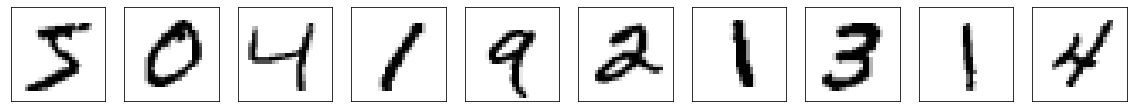

In [4]:
def plot(x, p, labels=False):
  plt.figure(figsize=(20,2))
  for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x[i].reshape(28,28), cmap='binary')
    plt.xticks([])
    plt.yticks([])
    if labels:
      plt.xlabel(np.argmax(p[i]))
  plt.show()

plot(x_train, None)

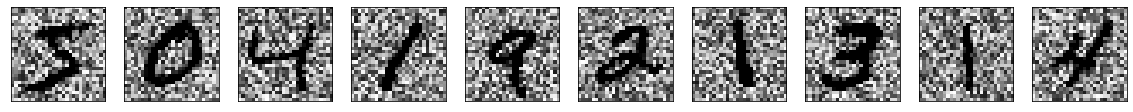

In [5]:
plot(x_train_noisy, None)

## Task 4: Building and Training a Classifier


In [6]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

classifier.fit(x_train,y_train,batch_size=512,epochs=5)


Epoch 1/5
118/118 [==============================] - 2s 16ms/step - loss: 0.4241 - accuracy: 0.8845
Epoch 2/5
118/118 [==============================] - 2s 16ms/step - loss: 0.1502 - accuracy: 0.9565
Epoch 3/5
118/118 [==============================] - 2s 16ms/step - loss: 0.1008 - accuracy: 0.9704
Epoch 4/5
118/118 [==============================] - 2s 16ms/step - loss: 0.0735 - accuracy: 0.9786
Epoch 5/5
118/118 [==============================] - 2s 16ms/step - loss: 0.0561 - accuracy: 0.9833


In [7]:
loss, acc = classifier.evaluate(x_test,y_test)     # Testing the accuracy over test data on trained model.
print(acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.0852 - accuracy: 0.9731
0.9731000065803528


In [8]:
loss, acc = classifier.evaluate(x_test_noisy,y_test)    # Testing the accuracy of predictions over noisy images on trained model.
print(acc)

313/313 [==============================] - 0s 1ms/step - loss: 9.8330 - accuracy: 0.1802
0.18019999563694


## Task 5: Building the Autoencoder


In [9]:
input_image = Input(shape=(784,))
encoded = Dense(64,activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image,decoded)
autoencoder.compile(loss='binary_crossentropy',optimizer='adam')

## Task 6: Training the Autoencoder


In [12]:
autoencoder.fit(
    x_train_noisy, x_train, epochs=100,
    batch_size=512, validation_split = 0.2, verbose=False,
    callbacks=[
               EarlyStopping(monitor='val_loss',patience=5),
               LambdaCallback(on_epoch_end=lambda e,l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
    ]
)


print(' _ ')
print('Training is Complete !')


0.115 _ 0.114 _ 0.113 _ 0.112 _ 0.111 _ 0.111 _ 0.110 _ 0.109 _ 0.108 _ 0.108 _ 0.108 _ 0.107 _ 0.107 _ 0.106 _ 0.106 _ 0.106 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.105 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.103 _ 0.104 _ 0.104 _ 0.104 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _  _ 
Training is Complete !


## Task 7: Denoised Images


In [14]:
predictions = autoencoder.predict(x_test_noisy)

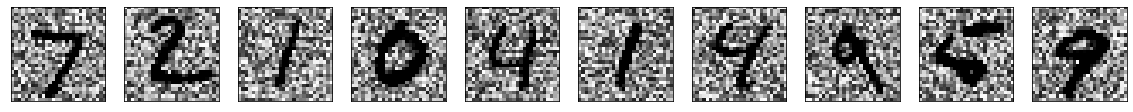

In [15]:
plot(x_test_noisy, None)

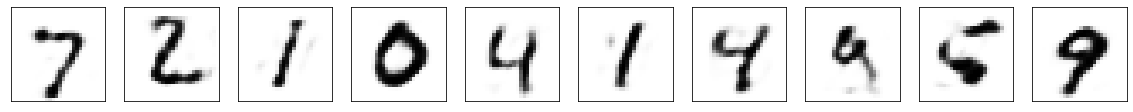

In [16]:
 plot(predictions, None)

In [17]:
loss, acc = classifier.evaluate(predictions,y_test)
print(acc)

313/313 [==============================] - 0s 2ms/step - loss: 0.1565 - accuracy: 0.9516
0.9516000151634216


## Task 8: Composite Model


In [18]:
input_image = Input(shape=(784,))
x = autoencoder(input_image)
y = classifier(x)

denoise_and_classify = Model(input_image, y)

In [19]:
predictions = denoise_and_classify.predict(x_test_noisy)

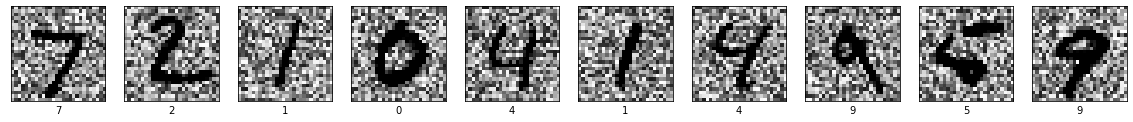

In [22]:
plot(x_test_noisy, predictions, True)

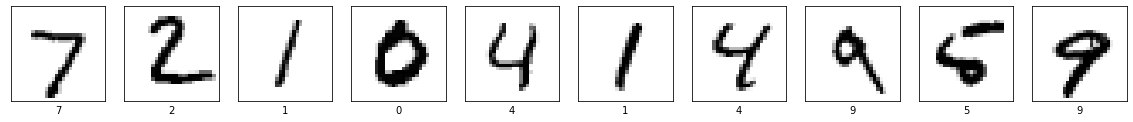

In [23]:
plot(x_test, to_categorical(y_test), True)